# MI-ADM: home assignment 1

  * **Deadline**: 28/04/2019, -2 points for a late submission, the hard deadline is the first day of the exam period.
  * **What to submit**: Just this notebook with you code and texts, not the dataset!
  * **How to submit**: See the instructions at https://courses.fit.cvut.cz/MI-ADM/tutorials/index.html.
  
Generally speaking, the goal of this assignment is to use **decision trees and related methods (boosted trees, random forests) for the regression problem**.

What to do:
  * Study the data from `house-prices.csv` (see also `house-prices_description.txt`) and prepare them for application of the algorithms (decision tree, random forest, XGBoost).
  * Treat the missing values and nominal/ordinal variables reasonably; experiment with various approaches.
  * Try to replace the continuous features with some discrete ones (indicator variables, dummy variables, binning, ...). 
  * Tune some reasonably selected hyperparameters (using cross-validation or just a validation set) and measure the results using *Root mean squared logarithmic error (RMSLE)*.

# Preprocessing

In [21]:
import pandas as pd
import math
import numpy as np
from sklearn import  preprocessing, model_selection, metrics, tree, feature_selection
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('house-prices.csv')
# the logarithm of SalesPrice must be used to evaluate RMSLE properly
# you can comment out the following line and apply the log just before evaluating RMSLE
df.SalePrice = df.SalePrice.apply(math.log) 
print(f'Features cnt: {df.shape[1]}')
print(f'Rows cnt: {df.shape[0]}')

Features cnt: 81
Rows cnt: 1460


In [22]:
#New features
df['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

for column in df.filter(regex='Area|SF', axis=1).columns: 
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print(f'Features cnt: {df.shape[1]}')

Features cnt: 112


In [23]:
# CLEANING
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')
# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

df = pd.get_dummies(df)

df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

print(f'Features cnt: {df.shape[1]}')

Features cnt: 321


In [24]:
#Removing features
df = df[df.columns[df.min() != df.max()]]

columns_to_remove = ['Id']
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: stats.ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

columns_to_remove = list(set(columns_to_remove + list(ttest_pvals[ttest_pvals > 0.6].index)))
df.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)

print(f'Features cnt: {df.shape[1]}')

Features cnt: 301


In [25]:
#Standardize 
columns = df.select_dtypes(include=['float64']).columns 
columns = columns.drop('SalePrice')
scaler = preprocessing.StandardScaler()
scaler.fit(df[columns])
df[columns] = scaler.transform(df[columns])

print(f'Features cnt: {df.shape[1]}')

Features cnt: 301


In [0]:
def get_rmsle(train_X, train_Y, val_test_X, val_test_Y, selected_model, select_features = True):
    
    if select_features:
        sfm = feature_selection.SelectFromModel(selected_model)
        sfm.fit(train_X, train_Y)

        train_X = sfm.transform(train_X)
        val_test_X = sfm.transform(val_test_X)
    
    model = selected_model.fit(train_X, train_Y)

    return np.sqrt(metrics.mean_squared_error(val_test_Y, model.predict(val_test_X)))

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop('SalePrice', axis=1), df.SalePrice, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(f'Train rows: {X_train.shape[0]}')
print(f'Val rows: {X_val.shape[0]}')
print(f'Test rows: {X_test.shape[0]}')

Train rows: 934
Val rows: 234
Test rows: 292


I will train all three models on test dataset. I will tune the hyperparameters on the validation dataset and measure the resulting RMSLE on the test dataset.

# Decision tree

In [0]:
res_mse = []
res_friedman = []
res_mae = []
max_depth =  50
for i in range(1,  max_depth):
    regr = tree.DecisionTreeRegressor(criterion='mse',splitter ='best', max_depth=i)
    rmsle_mse  = get_rmsle(X_train, y_train, X_val, y_val, regr)
    res_mse.append(rmsle_mse)
    
    regr = tree.DecisionTreeRegressor(criterion='friedman_mse',splitter ='best', max_depth=i)
    rmsle_friedman = get_rmsle(X_train, y_train, X_val, y_val, regr)
    res_friedman.append(rmsle_friedman)
    
    regr = tree.DecisionTreeRegressor(criterion='mae',splitter ='best', max_depth=i)
    rmsle_mae = get_rmsle(X_train, y_train, X_val, y_val, regr)
    res_mae.append(rmsle_mae)

Min MSE = 0.17306153810948435 Ideal depth = 6
Min Friedman = 0.17944970202920948 Ideal depth = 6
Min Mae = 0.17287249606858898 Ideal depth = 3


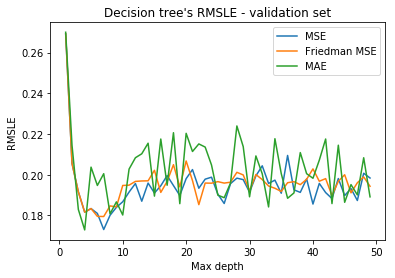

In [31]:
plt.plot([i for i in range(1, max_depth)], res_mse)
plt.plot([i for i in range(1, max_depth)], res_friedman)
plt.plot([i for i in range(1, max_depth)], res_mae)

plt.title('Decision tree\'s RMSLE - validation set')
plt.xlabel('Max depth')
plt.ylabel('RMSLE')
plt.legend(['MSE', 'Friedman MSE', 'MAE'])

print(f'Min MSE = {min(res_mse)} Ideal depth = {res_mse.index(min(res_mse))}')
print(f'Min Friedman = {min(res_friedman)} Ideal depth = {res_friedman.index(min(res_friedman))}')
print(f'Min Mae = {min(res_mae)} Ideal depth = {res_mae.index(min(res_mae))}')

## Decision tree results

In [32]:
regr = tree.DecisionTreeRegressor(criterion='mse',splitter ='best', max_depth=res_mse.index(min(res_mse)))
rmsle_mse  = get_rmsle(X_train, y_train, X_test, y_test, regr)
print(f'RMSLE with MSE criterion: {rmsle_mse}')

regr = tree.DecisionTreeRegressor(criterion='friedman_mse',splitter ='best', max_depth=res_friedman.index(min(res_friedman)))
rmsle_friedman = get_rmsle(X_train, y_train, X_test, y_test, regr)
print(f'RMSLE with MSE criterion: {rmsle_friedman}')

regr = tree.DecisionTreeRegressor(criterion='mae',splitter ='best', max_depth=res_mae.index(min(res_mae)))
rmsle_mae = get_rmsle(X_train, y_train, X_test, y_test, regr)
print(f'RMSLE with MSE criterion: {rmsle_mae}')

RMSLE with MSE criterion: 0.18380026303781363
RMSLE with MSE criterion: 0.18306419574126778
RMSLE with MSE criterion: 0.21833650273534985


I tried to tune these hyperparameters:
 - criterion
 - splitter
 - max_depth
 
 
For validation, the best RMSLE had configuration:
 - criterion = MAE
 - splitter = BEST
 - max_depth = 3
 - RMSLE = 0.1728
 
 
But after testing on test dataset, the best result had configuration:
 - criterion = MSE
 - splitter = BEST
 - max_depth = 6
 - ** RMSLE = 0.1872**

# Random forest 

Min RMSLE: 0.12382482685048675 - 120


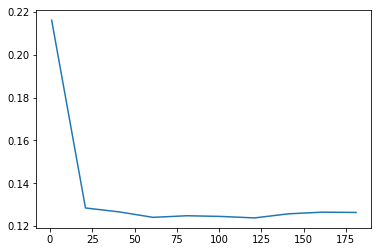

In [11]:
trees_res = []

for i in range(1, 201,20):
    regr = RandomForestRegressor(n_estimators = i)
    rmsle = get_rmsle(X_train, y_train, X_val, y_val, regr, True)
    trees_res.append(rmsle)
    
plt.plot([i for i in range(1, 201,20)], trees_res)
print(f'Min RMSLE: {min(trees_res)} - {trees_res.index(min(trees_res))*20}')

In [12]:
rf_params ={'n_estimators':[i for i in range(20, 220, 20)], 'criterion':['mse', 'mae'], 'max_depth': [None, 1, 5, 10, 20, 30]}
n_estimators_res = { 20:[], 40:[], 60:[], 80:[], 100:[], 120:[], 140:[], 160:[], 180:[], 200:[]}
criterion_res ={'mse':[], 'mae':[]}
max_depth_res = {None: [], 1:[], 5:[], 10:[], 20:[], 30:[]}
best_rmsle = 1
best_params = []
for n_estimators in rf_params['n_estimators']:
    print(n_estimators)
    for criterion in rf_params['criterion']:
        for max_depth in rf_params['max_depth']:
            regr = RandomForestRegressor(max_depth=max_depth,criterion= criterion, n_estimators=n_estimators)
            rmsle = get_rmsle(X_train, y_train, X_val, y_val, regr)
            
            if rmsle < best_rmsle:
                best_rmsle = rmsle
                best_params =[n_estimators, criterion, max_depth]
                
            n_estimators_res[n_estimators].append(rmsle)
            criterion_res[criterion].append(rmsle)
            max_depth_res[max_depth].append(rmsle)
                  
print(best_params)

20
40
60
80
100
120
140
160
180
200
[60, 'mse', 30]


## Random forest result

In [13]:
regr = RandomForestRegressor(max_depth=30,criterion= 'mse', n_estimators=60)
rmsle_rf  = get_rmsle(X_train, y_train, X_test, y_test, regr)
print(f'RMSLE: {rmsle_rf}')

RMSLE: 0.14443537282833777


I tried to tune these hyperparameters:
 - criterion
 - n_estimators
 - max_depth
 
 
For validation, the best RMSLE had configuration:
 - criterion = MSE
 - n_estimators = 60
 - max_depth = 30
 - RMSLE = 0.1222
 
 
**RMSLE on testing  dataset is 0.1444**


# XGBoost

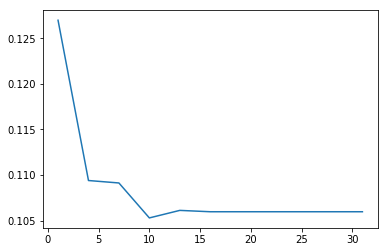

In [15]:
from xgboost.sklearn import XGBRegressor
# Depth

depth_res = []
for i in range(1, 32, 3):
    regr = XGBRegressor(max_depth=i, n_estimators=100, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)
    rmsle = get_rmsle(X_train, y_train, X_val, y_val, regr)
    depth_res.append(rmsle)

plt.plot([i for i in range(1, 32, 3)], depth_res)

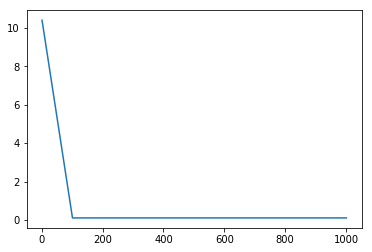

In [16]:
# n_estimators
n_estimators_res = []
for i in range(1, 1100, 100):
    regr = XGBRegressor(max_depth=10, n_estimators=i, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)
    rmsle = get_rmsle(X_train, y_train, X_val, y_val, regr)
    n_estimators_res.append(rmsle)
    
plt.plot([i for i in range(1, 1100, 100)], n_estimators_res)

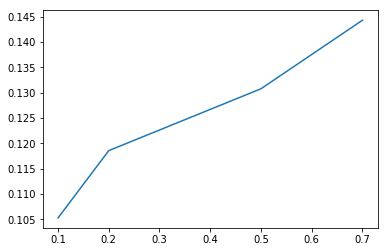

In [18]:
#learning_rate
lr_res = []
for  i in [0.1, 0.2, 0.5, 0.7]:
    regr = XGBRegressor(max_depth=10, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=i)
    rmsle = get_rmsle(X_train, y_train, X_val, y_val, regr)
    lr_res.append(rmsle)
    
plt.plot([ 0.1, 0.2, 0.5, 0.7], lr_res)

## XGBoost result

In [20]:
regr = XGBRegressor(max_depth=10,n_estimator= 100, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)
rmsle_xgb  = get_rmsle(X_train, y_train, X_test, y_test, regr)
print(f'RMSLE: {rmsle_xgb}')

RMSLE: 0.1388189985748904


For hyperparameters:
  - max_depth = 10
  - n_estimator = 100
  - learning_rate = 0.1

**RMSLE on testing dataset is 0.1388**